# Experiments with a (shallow) Convolutional Neural Network

Importing libraries:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras_tuner import HyperModel, GridSearch
from utils import get_clf_report_dfs, plot_confusion_matrix, get_trials_df

Defining constants:

In [2]:
RANDOM_SEED=42
MODEL_NAME="CNN"
RESULTS_DIR=f"./results/{MODEL_NAME}"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

Loading the data:

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

Defining the network architecture:

In [4]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        filters = hp.Choice('filters', values=[32, 64])
        num_conv_layers = hp.Choice('num_conv_layers', values=[2, 3, 4])
        dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.3])
        lr = hp.Choice('learning_rate', values=[1e-4, 1e-3])

        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=self.input_shape)) 
        for i in range(num_conv_layers):
            model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.ReLU())
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
        model.add(tf.keras.layers.GlobalAveragePooling1D())
        model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        return model

Displaying the hyperparameters space:

In [5]:
tuner = GridSearch(
    CNNHyperModel(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train))),
    objective='val_sparse_categorical_accuracy',
    seed=RANDOM_SEED,
    overwrite=True,
    directory=RESULTS_DIR,
    project_name='CNN_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
num_conv_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
dropout_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001], 'ordered': True}


Running the grid search:

In [6]:
num_epochs = 500
batch_size = 16
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
tuner.search(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)

Trial 24 Complete [00h 00m 46s]
val_sparse_categorical_accuracy: 0.75

Best val_sparse_categorical_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 31m 05s


Displaying grid search results:

In [7]:
get_trials_df(tuner)

,filters,num_conv_layers,dropout_rate,learning_rate,val_loss
2,32,2,0.300000,0.000100,0.587500
0,32,2,0.000000,0.000100,0.675000
3,32,2,0.300000,0.001000,0.675000
14,64,2,0.300000,0.000100,0.700000
6,32,3,0.300000,0.000100,0.700000
10,32,4,0.300000,0.000100,0.700000
13,64,2,0.000000,0.001000,0.712500
5,32,3,0.000000,0.001000,0.725000
9,32,4,0.000000,0.001000,0.725000
11,32,4,0.300000,0.001000,0.737500


Getting and displaying the best model:

In [8]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model._name = MODEL_NAME
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 150, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 150, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 150, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 150, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,545 (41.19 KB)

 Non-trainable params: 256 (1.00 KB)

Re-training to inspect learning curves:

In [9]:
history = best_model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)
best_model.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.keras"))

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8995 - sparse_categorical_accuracy: 0.0595 - val_loss: 2.8420 - val_sparse_categorical_accuracy: 0.0750 - learning_rate: 1.0000e-04
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7816 - sparse_categorical_accuracy: 0.1341 - val_loss: 2.8495 - val_sparse_categorical_accuracy: 0.1125 - learning_rate: 1.0000e-04
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7138 - sparse_categorical_accuracy: 0.1871 - val_loss: 2.8512 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6572 - sparse_categorical_accuracy: 0.2141 - val_loss: 2.8466 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6059 - sparse_categorical_accuracy: 0.2209 - val_loss: 2.8352 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 6/500
41/41 ━━━━━━━━━━━━━━━━━

Visualizing learning curves:

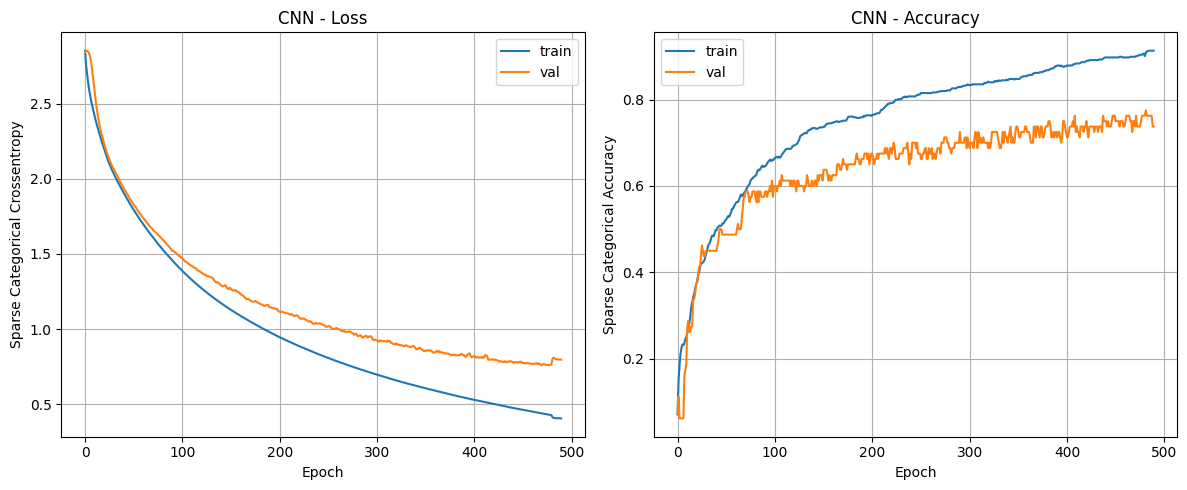

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history["loss"], label="train")
ax1.plot(history.history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Loss")
ax1.set_ylabel("Sparse Categorical Crossentropy")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(history.history["sparse_categorical_accuracy"], label="train")
ax2.plot(history.history["val_sparse_categorical_accuracy"], label="val")
ax2.set_title(f"{MODEL_NAME} - Accuracy")
ax2.set_ylabel("Sparse Categorical Accuracy")
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()

fig.tight_layout()

Displaying model loss and accuracy:

In [11]:
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
pd.DataFrame({
    "Dataset": ["Train", "Val", "Test"],
    "Loss": [train_loss, val_loss, test_loss],
    "Accuracy": [train_accuracy, val_accuracy, test_accuracy]
}).set_index("Dataset")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5437 - sparse_categorical_accuracy: 0.8285 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7290 - sparse_categorical_accuracy: 0.7617 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8724 - sparse_categorical_accuracy: 0.6950 


,Loss,Accuracy
Dataset,,
Train,0.548570,0.841369
Val,0.758487,0.750000
Test,0.882522,0.679012


Displaying model performance on the test set:

In [12]:
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.679012,0.680768,0.673759,0.711555,0.707128,0.688235,0.679012


In [13]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.500000,0.500000,0.500000,4.000000
bigball,0.750000,0.600000,0.666667,5.000000
box,0.800000,1.000000,0.888889,4.000000
button,0.500000,0.666667,0.571429,6.000000
case,1.000000,0.800000,0.888889,5.000000
cube,1.000000,0.750000,0.857143,4.000000
cylinder,0.500000,0.600000,0.545455,5.000000
empty,1.000000,1.000000,1.000000,5.000000
jenga,0.500000,0.250000,0.333333,4.000000
labello,1.000000,0.600000,0.750000,5.000000


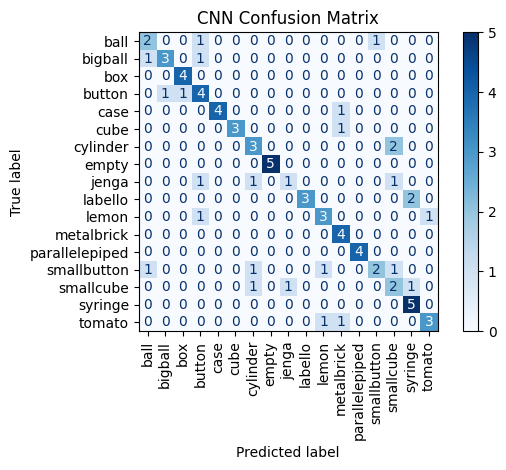

In [14]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)